# D0 Heterogeneity

This notebook tries to assess the heterogeneity among D0 fibroblast samples. 

In [ ]:
library(SnapATAC)
library(GenomicRanges)
library(GenomicFeatures)
library(ggplot2)
library(DESeq2)

In [2]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [3]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [96]:
# Metadata file from previous run
metaData = read.table("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')
metaData = metaData[order(metaData$sample_barcode), ]
head(metaData, 2)

,barcode,cluster,umap1,umap2,barcode.1,TN,UM,PP,UQ,CM,landmark,cluster.1,sample,sample_barcode
,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<chr>
1206,AAACAACGACGATTAC,6,2.515876,8.252824,AAACAACGACGATTAC,42629,38455,38381,33575,51,0,6,D0,D0_AAACAACGACGATTAC
1207,AAACAACGACTCACGG,6,2.355841,7.403916,AAACAACGACTCACGG,4424,4009,3998,3694,4,0,6,D0,D0_AAACAACGACTCACGG


In [5]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [95]:
metaData[as.character(metaData$sample)==DAYS[i], "barcode"]

NULL

In [6]:
x.sp.list

$D0
number of barcodes: 11133
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 9724
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 8726
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 10566
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D8
number of barcodes: 9895
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 4105
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 6334
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 16287
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [ ]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

In [8]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

Warning message:
“'rBind' is deprecated.
 Since R version 3.2.0, base's rbind() should work fine with S4 objects”


In [9]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [10]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap1", "umap2")])

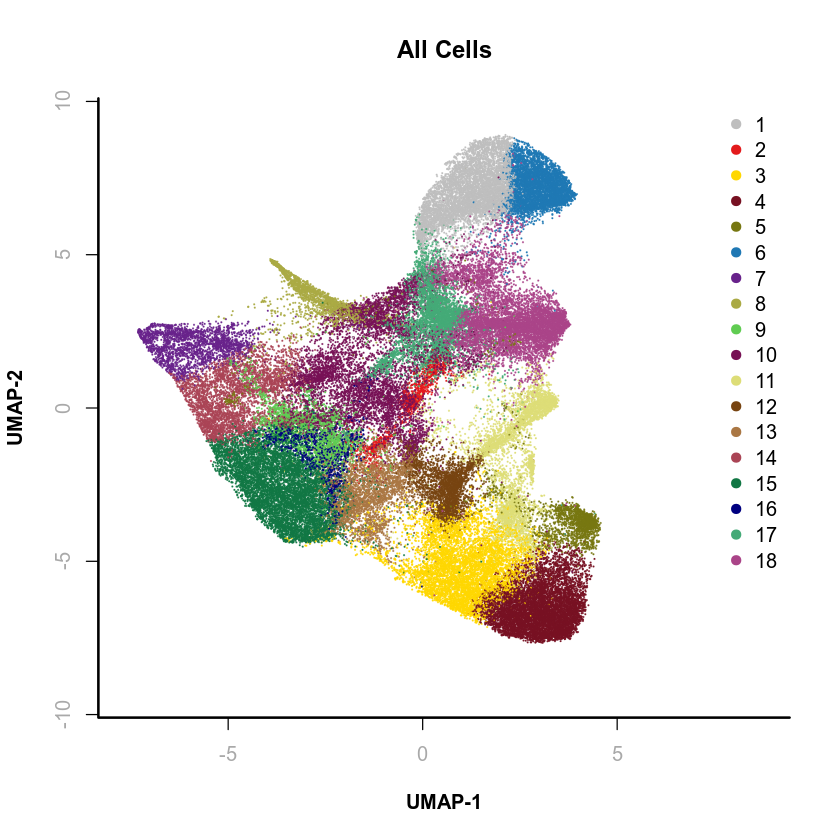

In [11]:
# verify all in order
plotViz(
    obj=x.sp,
    method="umap", 
    main="All Cells",
    point.color=x.sp@cluster, 
    point.size=0.1, 
    text.add= FALSE,
    down.sample=NULL,
    legend.add=TRUE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );

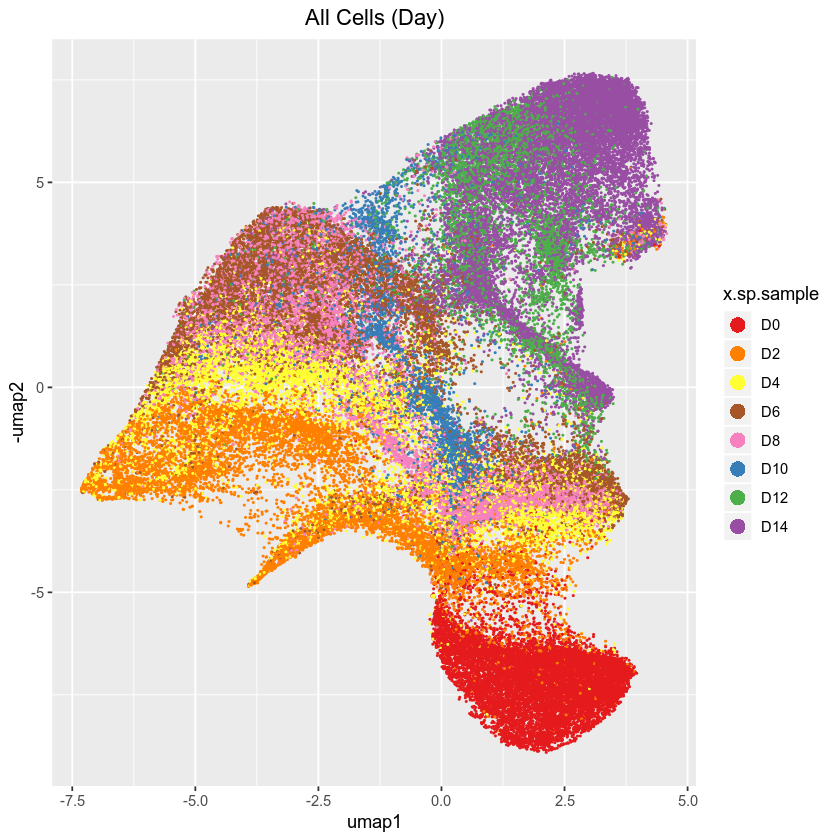

In [12]:
df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=-umap2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 
# ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
#                format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

In [13]:
table(metaData[metaData[,"cluster"]=="11", "sample"])


  D0  D10  D12  D14   D2   D4   D6   D8 
   2  110 1925 2300   16   40  181   14 

In [14]:
library(RColorBrewer)

In [15]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

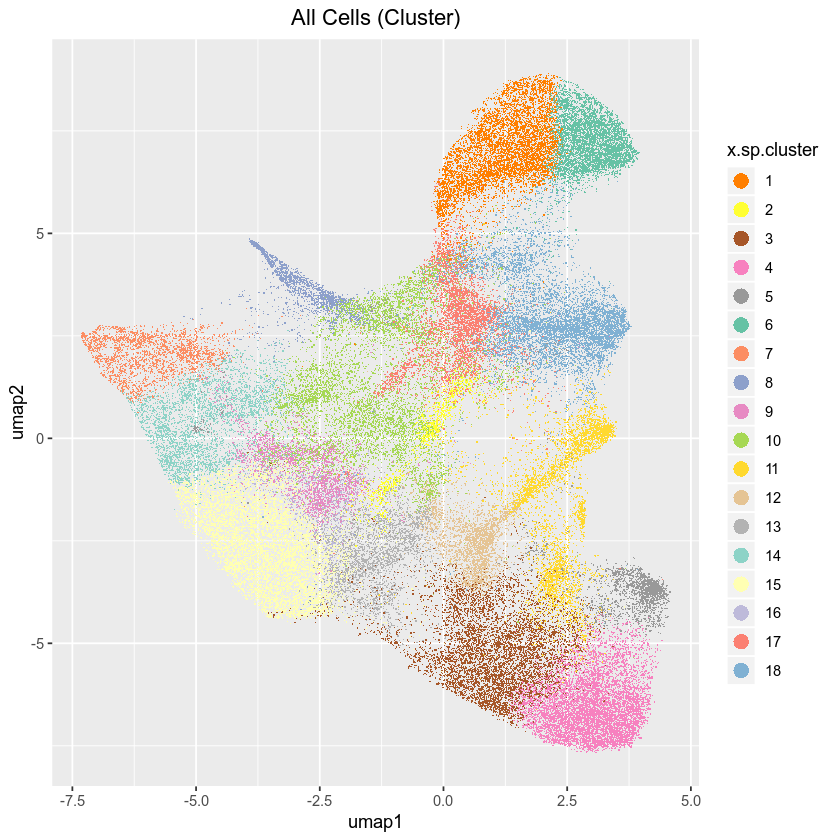

In [16]:
df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap1, y=umap2, col=x.sp.cluster)) +
geom_point(shape=".", size=2, alpha=1) +
scale_colour_manual(values = col_vector[seq(50,67)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Create Cluster Pseudo-bulk matrix

In [23]:
cluster1_cts = Matrix::colSums(x.sp[(x.sp@sample=="D0")&(x.sp@cluster=="1"),]@pmat)
cluster6_cts = Matrix::colSums(x.sp[(x.sp@sample=="D0")&(x.sp@cluster=="6"),]@pmat)

In [44]:
cts = data.frame(cluster1=cluster1_cts,
                cluster6=cluster6_cts,
                row.names=x.sp@peak)

In [59]:
intervals_gr = GRanges(rownames(cts))
intervals_gr

GRanges object with 467339 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       16147-16347      *
       [2]     chr1       51459-51659      *
       [3]     chr1       51689-52109      *
       [4]     chr1     180686-181260      *
       [5]     chr1     181268-181597      *
       ...      ...               ...    ...
  [467335]     chrY 25399202-25399408      *
  [467336]     chrY 26670497-26671505      *
  [467337]     chrY 56728041-56728241      *
  [467338]     chrY 56734685-56734895      *
  [467339]     chrY 56836760-56836960      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [45]:
head(cts)

,cluster1,cluster6
,<dbl>,<dbl>
chr1:16147-16347,27,8
chr1:51459-51659,1,0
chr1:51689-52109,1,1
chr1:180686-181260,96,65
chr1:181268-181597,58,47
chr1:184385-184585,29,16


In [46]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

## Differential Peaks

In [88]:
data.use = cts
group = factor(colnames(data.use), levels = colnames(data.use))
design = model.matrix(~0+group)
y = DGEList(counts=data.use, group=group)

In [89]:
et = exactTest(y, dispersion = 0.4^2)         
cur_diff_peaks = et$table[order(et$table$PValue),]

In [90]:
head(cur_diff_peaks)

,logFC,logCPM,PValue
,<dbl>,<dbl>,<dbl>
chr11:88975486-88975702,-8.010927,-1.7866909,0.0001262927
chr14:87869691-87869928,-4.535434,-0.8612567,0.0002162043
chr6:143482630-143482830,-7.859545,-1.9165522,0.0002407164
chr1:88284190-88284390,-4.983970,-1.3123298,0.0004447586
chr20:7196586-7196865,-4.675581,-1.5775402,0.0012817947
chr15:25611620-25611992,-3.628402,-1.1337574,0.0014571727


In [92]:
writeGRangesToBed <- function(gr, fname) {
    df <- data.frame(seqnames=seqnames(gr),
      starts=start(gr)-1,
      ends=end(gr),
      names=c(rep(".", length(gr))),
      scores=c(rep(".", length(gr))),
      strands=strand(gr))

    write.table(df, file=fname, quote=F, sep="\t", row.names=F, col.names=F)
}

writeGRangesToBed(GRanges(rownames(cur_diff_peaks[cur_diff_peaks$logFC<0,])[1:5000]),
                  "./beds/cluster1_up_5000.bed")
writeGRangesToBed(GRanges(rownames(cur_diff_peaks[cur_diff_peaks$logFC>0,])[1:5000]),
                  "./beds/cluster6_up_5000.bed")

## Gene Annotations

In [47]:
library(EnsDb.Hsapiens.v86)

Loading required package: ensembldb

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter




In [48]:
edb <- EnsDb.Hsapiens.v86

In [49]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [50]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 0)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 1 out-of-bound range located on sequence MT.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`trim,GenomicRanges-method` for more information."


In [51]:
head(prom.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames        ranges strand |   gene_name         gene_id
                     <Rle>     <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1   67091-69090      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1 180393-182392      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [55]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

## Make Gene x Cluster matrix

### Promoters Only

In [52]:
overlaps = findOverlaps(prom.hg38, intervals_gr)
overlaps

Hits object with 26514 hits and 0 metadata columns:
          queryHits subjectHits
          <integer>   <integer>
      [1]         2           4
      [2]         2           5
      [3]         6          59
      [4]         6          60
      [5]         7          80
      ...       ...         ...
  [26510]     22252      467091
  [26511]     22255      467113
  [26512]     22261      467310
  [26513]     22262      467324
  [26514]     22262      467325
  -------
  queryLength: 22285 / subjectLength: 467339

In [53]:
summed_gene = aggregate(cts[subjectHits(overlaps),], list(queryHits(overlaps)), sum)

# remove genes with duplicate entries
summed_gene = summed_gene[!duplicated(prom.hg38[summed_gene$Group.1]$gene_name) ,]
rownames(summed_gene) = prom.hg38[summed_gene$Group.1]$gene_name
summed_gene$Group.1 = NULL

# DESeq2 normalize
summed_gene = as.data.frame(t(t(summed_gene)/estimateSizeFactorsForMatrix(summed_gene)))

head(summed_gene)

,cluster1,cluster6
,<dbl>,<dbl>
FO538757.2,121.5590,141.8899
SAMD11,724.6180,720.8515
NOC2L,2114.6533,2034.6002
KLHL17,2114.6533,2034.6002
PLEKHN1,715.9353,530.8203
PERM1,351.2582,382.5960


### Inverse Distance Model

In [56]:
distal_overlaps = findOverlaps(tss.hg38+1000000, intervals_gr)
distal_overlaps

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 813 out-of-bound ranges located on sequences 1,
  10, 11, 12, 13, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9,
  CHR_HG1311_PATCH, CHR_HG2023_PATCH, CHR_HG2288_HG2289_PATCH,
  CHR_HSCHR11_1_CTG8, CHR_HSCHR11_2_CTG1, CHR_HSCHR11_3_CTG1,
  CHR_HSCHR12_1_CTG1, CHR_HSCHR12_2_CTG1, CHR_HSCHR13_1_CTG5,
  CHR_HSCHR16_CTG2, CHR_HSCHR17_1_CTG1, CHR_HSCHR17_1_CTG9,
  CHR_HSCHR17_2_CTG1, CHR_HSCHR17_2_CTG2, CHR_HSCHR17_3_CTG2,
  CHR_HSCHR18_3_CTG2_1, CHR_HSCHR19_5_CTG2, CHR_HSCHR1_2_CTG32_1,
  CHR_HSCHR1_ALT2_1_CTG32_1, CHR_HSCHR20_1_CTG3, CHR_HSCHR20_1_CTG4,
  CHR_HSCHR21_5_CTG2, CHR_HSCHR2_3_CTG15, CHR_HSCHR3_2_CTG3,
  CHR_HSCHR4_11_CTG12, CHR_HSCHR4_6_CTG12, CHR_HSCHR5_5_CTG1,
  CHR_HSCHR6_1_CTG5, CHR_HSCHR7_1_CTG1, CHR_HSCHR7_1_CTG7,
  CHR_HSCHR7_2_CTG1, CHR_HSCHR8_2_CTG7, CHR_HSCHR8_4_CTG1,
  CHR_HSCHRX_1_CTG3, CHR_HSCHRX_2_CTG3, GL000009.2, GL000194.1,
  GL000195.1, GL000205.2, GL0002

Hits object with 8275864 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1           1
        [2]         1           2
        [3]         1           3
        [4]         1           4
        [5]         1           5
        ...       ...         ...
  [8275860]     22282      467334
  [8275861]     22282      467335
  [8275862]     22283      467335
  [8275863]     22284      467335
  [8275864]     22285      467335
  -------
  queryLength: 22285 / subjectLength: 467339

In [57]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove genes with duplicate entries
distal_summed_gene = distal_summed_gene[!duplicated(tss.hg38[distal_summed_gene$Group.1]$gene_name) ,]
rownames(distal_summed_gene) = tss.hg38[distal_summed_gene$Group.1]$gene_name
distal_summed_gene$Group.1 = NULL

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

,cluster1,cluster6
,<dbl>,<dbl>
OR4F5,2531.978,2589.152
FO538757.2,4417.342,4674.190


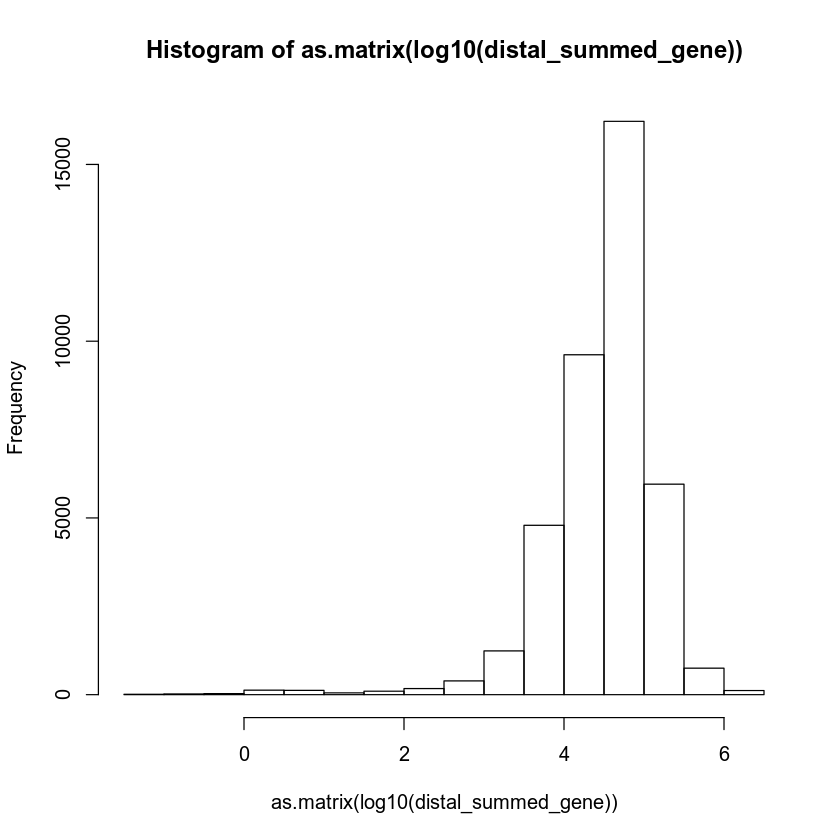

In [60]:
hist(as.matrix(log10(distal_summed_gene)))

In [61]:
common_genes = intersect(rownames(summed_gene), rownames(distal_summed_gene))
length(common_genes)

[1] 15867

## Diff Genes

In [68]:
library(edgeR)

Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:DESeq2':

    plotMA


The following object is masked from 'package:BiocGenerics':

    plotMA




In [82]:
data.use = summed_gene
group = factor(colnames(data.use), levels = colnames(data.use))
design = model.matrix(~0+group)
y = DGEList(counts=data.use, group=group)

In [83]:
et = exactTest(y, dispersion = 0.4^2)         
cur_diff_peaks = et$table[order(et$table$PValue),]

In [84]:
head(cur_diff_peaks)

,logFC,logCPM,PValue
,<dbl>,<dbl>,<dbl>
NRXN3,-6.138787,-1.834253,0.02277515
TEX15,-2.047259,1.172490,0.03071639
TAF15,-1.926659,2.264230,0.03120988
GTF2A1L,-6.003330,-1.926959,0.03276425
RALYL,-3.103754,-1.402535,0.03478097
ACMSD,-1.834229,2.754097,0.03869931


## Write Gene Lists

In [85]:
LIST_PATH = sprintf("gene_lists/cluster1_up_promoter_ranked.txt")
fileConn = file(LIST_PATH)
writeLines(rownames(cur_diff_peaks[cur_diff_peaks$logFC<0,]), fileConn)
close(fileConn)

LIST_PATH = sprintf("gene_lists/cluster6_up_promoter_ranked.txt")
fileConn = file(LIST_PATH)
writeLines(rownames(cur_diff_peaks[cur_diff_peaks$logFC>0,]), fileConn)
close(fileConn)